## Logistic Regression Example

This notebook demonstrates training of logistic classifiers based on single features from dimensionality reduction methods and their best-corresponding regions of anatomy.

In [9]:
import pandas as pd

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve

from imio import load

import matplotlib.pyplot as plt

from morphontogeny.functions.IO import reconstruct_ABA

NUM_GENES = 10 # the number of genes to pick for classification.

In [10]:
# Load Allen gene expression data.
data = np.memmap("/data/bioprotean/ABA/MEMMAP/genes_list/finalgenes_T.mymemmap", dtype='float32', mode='r', shape=(159326,2941))

# Load Allen anatomical labels.
labels = load.load_any("/data/bioprotean/ABA/Template/allen_annot200.nii").flatten()

DF = pd.DataFrame(data)

DF['labels'] = labels

# Filter out any samples which aren't located inside any anatomical region.
data = DF[(DF['labels'] != 0.0)]

data.reset_index(inplace=True)

In [11]:
# Learned weights for sparse filtering features.
SF_weights = pd.read_csv('/data/bioprotean/ABA/SFT/mask/100_weights_df.csv', index_col='Unnamed: 0') 

# The genes associated with the ten largest weights which produce sparse fitlering feature 94.
SF_weights.sort_values(by='feature_94', ascending=False, key=abs).head(NUM_GENES)

,Old Index,Gene,Entrez ID,Image Series URL,Used in analysis?,ID,feature_0,feature_1,feature_2,feature_3,...,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99
1053,1091,Fibcd1,98970,Fibcd1/72472801.html,1,72472801,2.501477e+06,2.788517e+06,316979.105037,1.069551e+05,...,3.192324e+05,293569.092133,362974.307057,1.609835e+06,6.143737e+06,1.591770e+05,3.111031e+05,1.539878e+05,5.901023e+05,2.356865e+06
332,343,Arl15,218639,Arl15/74363341.html,1,74363341,1.286817e+06,6.490998e+06,112633.740009,1.806258e+05,...,3.229592e+05,167353.337450,93574.211851,3.753319e+05,5.446541e+06,2.269875e+05,2.478182e+05,1.518416e+05,6.249846e+04,1.029131e+06
516,530,C630041L24Rik,78709,C630041L24Rik/72129253.html,1,72129253,2.366643e+06,2.421249e+06,63161.676671,3.346837e+05,...,9.069050e+05,126886.040523,31020.062748,1.080573e+06,5.273890e+06,9.862120e+05,4.006064e+05,2.235534e+05,2.276220e+05,1.692799e+06
2553,2639,Sstr4,20608,Sstr4/73636037.html,1,73636037,1.311203e+06,3.164067e+06,31319.643241,4.599294e+05,...,4.978446e+05,87683.202275,826142.919174,6.747978e+05,4.459002e+06,2.913044e+05,3.432786e+05,6.363410e+04,2.358985e+05,1.402024e+06
2634,2721,TC1412430,0,TC1412430/73615573.html,1,73615573,1.139626e+06,3.534278e+06,555055.534006,5.663179e+04,...,4.292243e+05,234868.758456,721605.511203,7.897202e+05,3.941877e+06,1.907173e+05,6.366858e+05,8.020256e+05,2.467391e+05,2.797692e+05
1652,1710,Matn2,17181,Matn2/73817421.html,1,73817421,2.105528e+06,2.888108e+06,5109.763022,9.232372e+04,...,7.219068e+05,408778.848706,117254.500060,1.064978e+06,3.825980e+06,1.032847e+06,1.829672e+05,3.321124e+04,7.657840e+05,1.717107e+06
741,763,Cpne8,66871,Cpne8/73520974.html,1,73520974,1.397551e+06,4.003398e+04,379142.470150,1.278869e+05,...,6.103435e+05,715287.985632,229869.755129,4.348645e+05,3.730127e+06,2.279502e+05,1.872133e+06,1.008823e+06,1.050235e+06,1.471507e+06
320,331,Arhgap12,75415,Arhgap12/71836846.html,1,71836846,4.394224e+05,2.837646e+06,351905.166498,5.803606e+05,...,4.983258e+05,762429.829768,267783.305129,8.399102e+05,3.681845e+06,3.408470e+05,7.437312e+05,1.576671e+05,5.076226e+05,1.260102e+06
904,933,Dock10,210293,Dock10/74047443.html,1,74047443,3.893745e+06,8.819737e+04,688301.149925,1.559877e+06,...,1.021177e+06,570158.979529,254361.915623,2.759612e+06,3.047408e+06,9.515756e+05,7.342837e+05,3.987214e+05,1.902383e+05,1.744552e+06
1447,1499,Kcnd2,16508,Kcnd2/71020432.html,1,71020432,8.947203e+05,1.812316e+06,334119.915254,5.539482e+05,...,2.983104e+05,216502.889547,106381.850848,6.282379e+05,3.042676e+06,4.232119e+05,8.406670e+04,4.247456e+05,3.150511e+05,9.639200e+05


In [12]:
# The anatomical region which corresponds most to SFt 94 is CA1.
# Recover the unique indices associated with these genes.

CA1_gene_indices = SF_weights.sort_values(by='feature_94', ascending=False, key=abs).head(NUM_GENES).index.tolist()

In [13]:
# Identify the integer label associated with region CA1, which is 382.

structures = pd.read_csv('/data/bioprotean/ABA/SFT/mask/100f_200c_max_DICE.csv', index_col='Unnamed: 0')
structures[ structures.acronym == '"CA1"' ]

,full_ant_index,structure,acronym,ish_id,ant_id,in_200_atlas,region_overlap_ratio,jac_overlap_ratio,DICE_neg_jcb_anat,max_DICE
223,457,"""Field CA1""","""CA1""",47.0,382,True,0.002315,0.001005,0.001402,0.621389


In [16]:
# Subset the data to only include the 10 highest-weighted genes.
X = data[ CA1_gene_indices ]

# Mean-center and standard-scale the subsetted data.
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Generate boolean labels for whether a given sample is within the region of interest.
y = (data[['labels']].to_numpy() == 382.0)

# Randomly split the data, stratifying it such that neither negative or positive classes are overepresented on either side of the split.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42, stratify=y)

In [17]:
# Fit the model.
lr = LogisticRegression()
lr.fit(X_train,y_train)

# Generate class probability predictions for the test set.
pred = lr.predict_proba(X_test)

# Measure the ROC-AUC performance of the model.
roc_auc_score(y_test, pred[:,1])

/home/csanderf/.conda/envs/lr_work/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9795357689189244

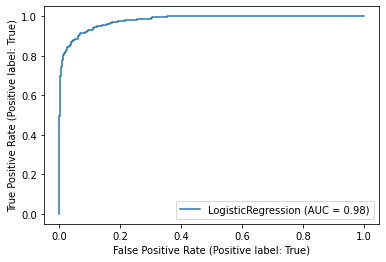

In [18]:
plot_roc_curve(lr, X_test, y_test)

In [19]:
# Cross-validate the ROC-AUC metric, using fivefold cross-validation.
scores = cross_validate(lr, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
print(sum(scores['test_score'])/5)

0.9779451033406341


/home/csanderf/.conda/envs/lr_work/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/csanderf/.conda/envs/lr_work/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/csanderf/.conda/envs/lr_work/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/csanderf/.conda/envs/lr_work/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 